In [1]:
!pip install transformers datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datasets import Dataset
from transformers import BertTokenizerFast, TFBertForSequenceClassification
import tensorflow as tf

# Data Loading

In [3]:
from datasets import load_dataset
import pandas as pd

# Load Civil Comments from Huggingface
civil_comments = load_dataset('google/civil_comments')
df_civil = pd.DataFrame(civil_comments['train'])
print('Civil Comments shape:', df_civil.shape)
print(df_civil[['text', 'toxicity']].head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.73k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Civil Comments shape: (1804874, 8)
                                                text  toxicity
0  This is so cool. It's like, 'would you want yo...  0.000000
1  Thank you!! This would make my life a lot less...  0.000000
2  This is such an urgent design problem; kudos t...  0.000000
3  Is this something I'll be able to install on m...  0.000000
4               haha you guys are a bunch of losers.  0.893617


# Data Preprocessing

In [4]:
# Cleaning the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip()

# Apply clean text
df_civil['text_clean'] = df_civil['text'].astype(str).apply(clean_text)
# Convert toxicity values to boolean (0 if non-toxic, 1 if toxic)
df_civil['toxic'] = (df_civil['toxicity'] >= 0.5).astype(int)
# Drop unneccesary columns
df_civil = df_civil[['text_clean', 'toxic']].dropna()

# Separate toxic and non-toxic comments
toxic = df_civil[df_civil['toxic'] == 1]
nontoxic = df_civil[df_civil['toxic'] == 0]

######### DOWNSAMPLE #########
# Downsample non-toxic to match the number of toxic samples
nontoxic_downsampled = nontoxic.sample(len(toxic), random_state=42)

# Concatenate and shuffle
df_balanced = pd.concat([toxic, nontoxic_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class balance
print(df_balanced['toxic'].value_counts())
##############################

# Sample for speed during experimentation - Increase the n_samples
n_samples = 100000
df_balanced = df_balanced.sample(n_samples, random_state=42) #change from df_balanced to df_civil if not balanced

# Train/test split
#train_df, test_df = train_test_split(
#    df_civil, test_size=0.2, random_state=42, stratify=df_civil['toxic']
#)

# Train/test split
train_df, test_df = train_test_split(
    df_balanced,
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['toxic']
)

# Split train_df further into train and validation
train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df['toxic']
)

# Show the results after split. Should be approx. 72% train, 20% test and 8% validation.
# Toxic comments represent close to 50% after balancing.
print("Train toxic:", train_df['toxic'].sum(), "/", len(train_df))
print("Test toxic:", test_df['toxic'].sum(), "/", len(test_df))
print("Test toxic:", val_df['toxic'].sum(), "/", len(val_df))

toxic
1    144334
0    144334
Name: count, dtype: int64
Train toxic: 35991 / 72000
Test toxic: 9997 / 20000
Test toxic: 3999 / 8000


# Train

In [5]:
# Convert to Huggingface Dataset
train_hf = Dataset.from_pandas(train_df)
val_hf = Dataset.from_pandas(val_df)
test_hf = Dataset.from_pandas(test_df)


# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_batch(batch):
    return tokenizer(
        batch['text_clean'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

train_hf = train_hf.map(tokenize_batch, batched=True)
val_hf = val_hf.map(tokenize_batch, batched=True)
test_hf = test_hf.map(tokenize_batch, batched=True)


# Set format for TensorFlow
train_hf.set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'toxic'])
val_hf.set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'toxic'])
test_hf.set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'toxic'])



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/72000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [6]:
# Convert to tf.data.Dataset
def to_tf_dataset(hf_dataset, batch_size=32, shuffle=True):
    features = {
        'input_ids': tf.TensorSpec(shape=(None,), dtype=tf.int32),
        'attention_mask': tf.TensorSpec(shape=(None,), dtype=tf.int32),
    }
    def gen():
        for ex in hf_dataset:
            yield {
                'input_ids': ex['input_ids'],
                'attention_mask': ex['attention_mask'],
            }, ex['toxic']
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            features,
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    return ds

tf_train = to_tf_dataset(train_hf, batch_size=32, shuffle=True)
tf_val = to_tf_dataset(val_hf, batch_size=32, shuffle=False)
tf_test = to_tf_dataset(test_hf, batch_size=32, shuffle=False)

In [7]:
# Load BERT model for binary classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
history = model.fit(
    tf_train,
    validation_data=tf_val,
    epochs=1
)

2250/2250 [==============================] - 275s 122ms/step - loss: 0.0803 - accuracy: 0.9717 - val_loss: 0.4327 - val_accuracy: 0.8820


In [18]:
# Predict
preds = model.predict(tf_test).logits
y_pred = np.argmax(preds, axis=1)

# True labels
y_true = np.concatenate([y for x, y in tf_test], axis=0)

625/625 [==============================] - 41s 66ms/step


In [19]:
# Report
print("CLASSIFICATION REPORT")
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

# Overall accuracy
print("\nOverall Metrics")
print("-" * 30)
print(f"{'Accuracy:':<25} {report['accuracy']:.4f}")
print(f"{'Weighted F1-score:':<25} {report['weighted avg']['f1-score']:.4f}")

# Toxic (class 1)
print("\nToxic Comments (class = 1)")
print("-" * 30)
print(f"{'Precision:':<25} {report['1']['precision']:.4f}")
print(f"{'Recall:':<25} {report['1']['recall']:.4f}")
print(f"{'F1-score:':<25} {report['1']['f1-score']:.4f}")

# Non-toxic (class 0)
print("\nNon-toxic Comments (class = 0)")
print("-" * 30)
print(f"{'Precision:':<25} {report['0']['precision']:.4f}")
print(f"{'Recall:':<25} {report['0']['recall']:.4f}")
print(f"{'F1-score:':<25} {report['0']['f1-score']:.4f}")


CLASSIFICATION REPORT

Overall Metrics
------------------------------
Accuracy:                 0.8804
Weighted F1-score:        0.8804

Toxic Comments (class = 1)
------------------------------
Precision:                0.8789
Recall:                   0.8824
F1-score:                 0.8806

Non-toxic Comments (class = 0)
------------------------------
Precision:                0.8820
Recall:                   0.8785
F1-score:                 0.8803


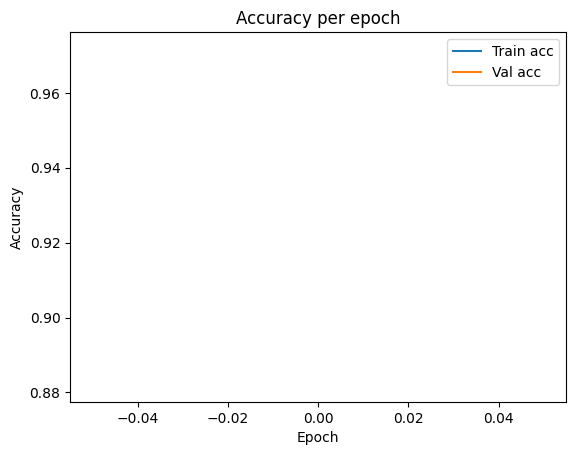

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per epoch')
plt.show()

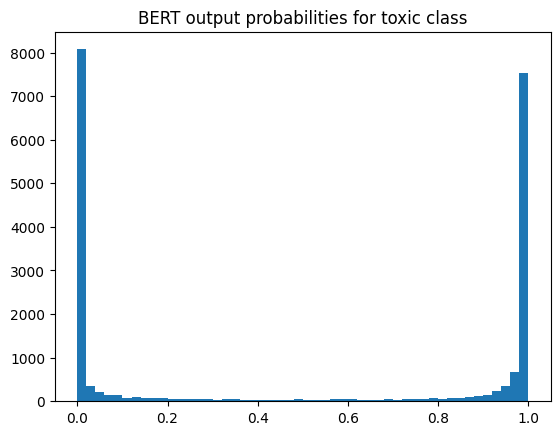

In [21]:
import matplotlib.pyplot as plt
probs = tf.nn.softmax(preds, axis=1)[:,1].numpy()
plt.hist(probs, bins=50)
plt.title("BERT output probabilities for toxic class")
plt.show()

# Test

In [22]:
def predict_toxic(text, model, tokenizer):
    # Clean the text as during training
    def clean_text(txt):
        txt = txt.lower()
        txt = re.sub(r'\n', ' ', txt)
        txt = re.sub(r'\[.*?\]', '', txt)
        txt = re.sub(r'https?://\S+|www\.\S+', '', txt)
        txt = re.sub(r'[^a-zA-Z0-9\s]', '', txt)
        return txt.strip()

    cleaned = clean_text(text)
    inputs = tokenizer(
        cleaned,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='tf'
    )
    logits = model(inputs).logits
    probs = tf.nn.softmax(logits, axis=1).numpy()[0]
    pred_class = np.argmax(probs)
    if pred_class == 1:
        print("This comment is toxic.")
    else:
        print("This comment is non-toxic.")



In [23]:
# Example usage:
comment = "You are stupid"
predict_toxic(comment, model, tokenizer)

This comment is toxic.


In [24]:
# Save model
model.save_pretrained("model")

# Save tokenizer
tokenizer.save_pretrained("model")

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')

# Deployment through Gradio

In [25]:
code = '''
import gradio as gr
import re
import numpy as np
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizerFast

# Load saved model and tokenizer
model = TFBertForSequenceClassification.from_pretrained("model")
tokenizer = BertTokenizerFast.from_pretrained("model")

def predict_toxic_gradio(text):
    def clean_text(txt):
        txt = txt.lower()
        txt = re.sub(r'\\n', ' ', txt)
        txt = re.sub(r'\\[.*?\\]', '', txt)
        txt = re.sub(r'https?://\\S+|www\\.\\S+', '', txt)
        txt = re.sub(r'[^a-zA-Z0-9\\s]', '', txt)
        return txt.strip()

    cleaned = clean_text(text)
    inputs = tokenizer(cleaned, truncation=True, padding='max_length', max_length=128, return_tensors='tf')
    logits = model(inputs).logits
    probs = tf.nn.softmax(logits, axis=1).numpy()[0]
    pred_class = np.argmax(probs)
    return "<div class='output-text'>This comment is toxic 👎</div>" if pred_class == 1 else "<div class='output-text'>This comment is non-toxic 👍</div>"

with gr.Blocks(css=\"\"\"
#main-container {
    display: flex;
    flex-direction: column;
    align-items: center;
    justify-content: center;
    max-width: 500px;
    margin: 5rem auto 0 auto;
    background-color: transparent !important;
}

.output-text {
    color: white;
    font-size: 24px;
    text-align: center;
    margin-bottom: 1em;
}

.shrink-box {
    max-width: 500px;
    width: 100%;
}

.centered-text {
    text-align: center;
    color: white;
    margin-bottom: 0.5em;

}

\"\"\") as demo:
    with gr.Column(elem_id=\"main-container\"):
        gr.Markdown(\"<h1 class='centered-text'>Toxicity Detector</h1>\")
        gr.Markdown(\"<p class='centered-text'>This Transformer-based model lets you test to check if a comment is toxic or not. Try it yourself in the box below.</p>\")
        output = gr.HTML(\"\")
        input_box = gr.Textbox(lines=3, placeholder=\"Enter a comment here...\", label=\"Comment\", elem_classes=[\"shrink-box\"])
        button = gr.Button(\"Check for toxicity\", elem_classes=[\"shrink-box\"])
        button.click(fn=predict_toxic_gradio, inputs=input_box, outputs=output)

demo.launch()
'''

with open("app.py", "w") as f:
    f.write(code)